# Correlations and Chi squared

This script finds the correlations between numerical features of the EPC data and performs a chi-squared test on all EPC variables

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '/config-example.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_fname = config['DEFAULT']['epc_train_fname']
epc_fname_suffix = config['DEFAULT']['epc_fname_suffix']
epc_test_fname = config['DEFAULT']['epc_test_fname']

In [3]:
dtype_dict = {'INSPECTION_DATE':'str'}

epc_train = pd.read_csv(os.path.join(processing_path,epc_train_fname) + epc_fname_suffix,
                        header = 0,
                        delimiter = ',',
                        dtype = dtype_dict,
                        parse_dates = ['INSPECTION_DATE'])

epc_test = pd.read_csv(os.path.join(processing_path,epc_test_fname) + epc_fname_suffix,
                        header = 0,
                        delimiter = ',',
                        dtype = dtype_dict,
                        parse_dates = ['INSPECTION_DATE'])

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_15284\4240386557.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  epc_train = pd.read_csv(os.path.join(processing_path,epc_train_fname) + epc_fname_suffix,
C:\Users\KingRemy\AppData\Local\Temp\ipykernel_15284\4240386557.py:9: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  epc_test = pd.read_csv(os.path.join(processing_path,epc_test_fname) + epc_fname_suffix,


In [4]:
#Numeric
var_list_num = epc_train.select_dtypes(include= 'number').columns.tolist()
var_list_num.remove('BUILDING_REFERENCE_NUMBER')

#Categorical
var_list_cat = epc_train.select_dtypes(include= ['object','category']).columns.tolist()
var_list_cat.remove('LMK_KEY')
var_list_cat.remove('POSTCODE')
var_list_cat.remove('CURRENT_ENERGY_RATING')

### Numeric features correrlations against the other fields in the taxonomy  

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_15284\1959966665.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_energy_costs, dtype=np.bool)


<AxesSubplot:>

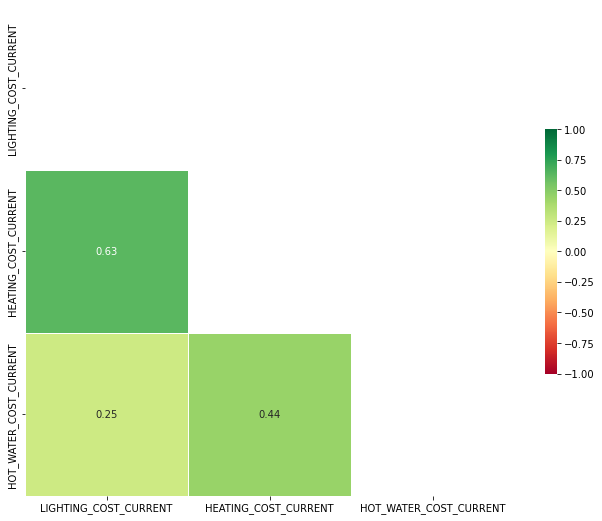

In [5]:
# Correlation of energy cost
corr_energy_costs = epc_train[['LIGHTING_COST_CURRENT',
                               'HEATING_COST_CURRENT',
                               'HOT_WATER_COST_CURRENT']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_energy_costs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_energy_costs, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_15284\3634726014.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_house_desc, dtype=np.bool)


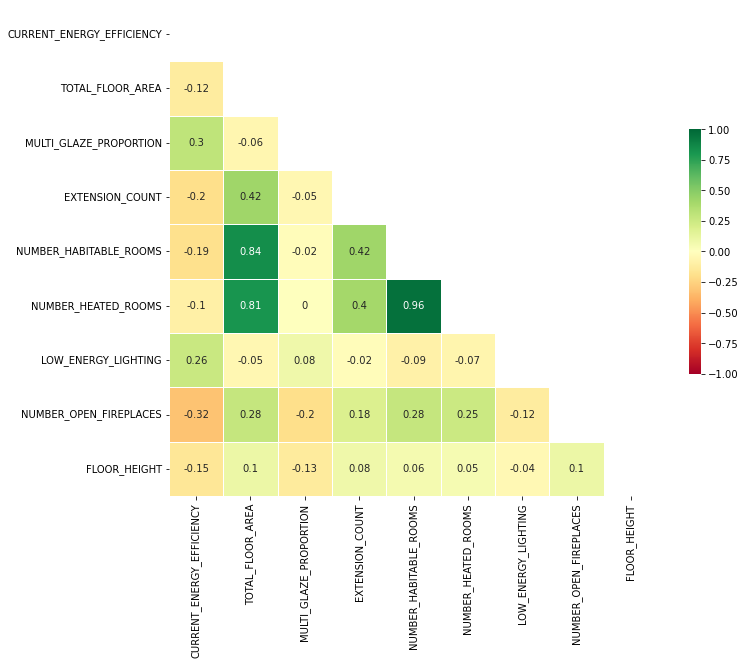

In [6]:
#House descriptions
corr_house_desc = epc_train[[ 'CURRENT_ENERGY_EFFICIENCY',
                            'TOTAL_FLOOR_AREA',
                            'MULTI_GLAZE_PROPORTION',
                            'EXTENSION_COUNT',
                            'NUMBER_HABITABLE_ROOMS',
                            'NUMBER_HEATED_ROOMS',
                            'LOW_ENERGY_LIGHTING',
                            'NUMBER_OPEN_FIREPLACES',
                            'FLOOR_HEIGHT']].corr()
# plot correlations
corr_house_desc = round(corr_house_desc,2)
mask = np.zeros_like(corr_house_desc, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_house_desc, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_15284\341691263.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_all, dtype=np.bool)


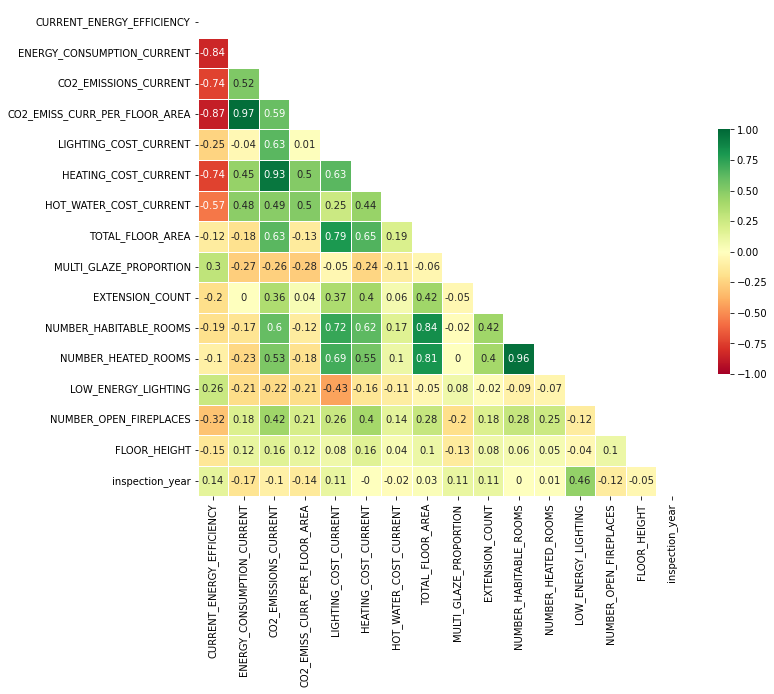

In [7]:
corr_all = epc_train[var_list_num].corr()

# plot correlations
corr_all = round(corr_all,2)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_all, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Categorical features Chi-Squared test of independence between variables in taxonomy
if Chi-squared > crit_value reject the null hypothesis that there is no relationship between both variables        Uplift is a measure of the uplift between the chi squared metric and the critical value (I am assuming that the larger the uplift. The stronger the relastionship between the features (assumption)

In [8]:
#Function to run a series of chi-squared independance tests for all the
#possible combinations of a variable within a dataframe

def get_chi_squared_all(df):
    
    ''' 
    Performs a chi-squared test between all variables in the dataframe
    Parameters
      df: a dataframe
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var1 in df.columns.values:
        for var2 in df.columns.values: 
            if(var1 != var2):
                xtab = pd.crosstab(df[var1],df[var2])
                res = stats.chi2_contingency(xtab)
                chi_squred_crit_value = stats.chi2.ppf(q = 0.95,            # Find teh critical value for 95% confidence
                                                        df = res[2])        # Df = number of variable categories - 1
                #TODO I don't think printing all this is helpful, it's too fast to see
                print(f"\nResults for {var1} and {var2}")
                print(f"\tChi-squared:\t{res[0]}")
                print(f"\tP-value:\t{res[1]}")
                print(f"\tDoF:\t\t{res[2]}")
                print(f"\tCrit-value:\t{chi_squred_crit_value}")
                print(f"\tUplift:\t\t{res[0] / chi_squred_crit_value}")
                results_buffer[(var1, var2)] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)

chi2_all = get_chi_squared_all(epc_train[var_list_cat])


Results for region and PROPERTY_TYPE
	Chi-squared:	350043.844963
	P-value:	0.000000
	DoF:		440
	Crit-value:	489.904544
	Uplift:		714.514387

Results for region and BUILT_FORM
	Chi-squared:	296022.801459
	P-value:	0.000000
	DoF:		550
	Crit-value:	605.666770
	Uplift:		488.755230

Results for region and COUNTY
	Chi-squared:	88831106.000000
	P-value:	0.000000
	DoF:		2530
	Crit-value:	2648.130434
	Uplift:		33544.837846

Results for region and TRANSACTION_TYPE
	Chi-squared:	372895.384514
	P-value:	0.000000
	DoF:		1870
	Crit-value:	1971.716041
	Uplift:		189.122255

Results for region and ENERGY_TARIFF
	Chi-squared:	203051.921110
	P-value:	0.000000
	DoF:		880
	Crit-value:	950.123665
	Uplift:		213.711045

Results for region and MAINS_GAS_FLAG
	Chi-squared:	208276.935743
	P-value:	0.000000
	DoF:		110
	Crit-value:	135.480178
	Uplift:		1537.324049

Results for region and FLOOR_LEVEL
	Chi-squared:	197070.179109
	P-value:	0.000000
	DoF:		7920
	Crit-value:	8128.147222
	Uplift:		24.245400

Results fo

KeyboardInterrupt: 

In [ ]:
#Function to run a series of chi-squared independance tests for all the
#features against the target
def get_chi_squared_target(df,target,feature_list):
    
    ''' 
    Performs a chi-squared test between specified variables in the dataframe
    Parameters
      df: a dataframe
      target: string, a variable you want to be in every chi-squared
      feature_list: list, the other variables you want to test the target with
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var in feature_list:
        xtab = pd.crosstab(df[target],df[var])
        res = stats.chi2_contingency(xtab)
        chi_squred_crit_value = stats.chi2.ppf(q = 0.95,df = res[2])
        print("\nResults for %s and %s" % (target, var))
        print("\tChi-squared:\t%f" % res[0])
        print("\tP-value:\t%f" % res[1])
        print("\tDoF:\t\t%i" % res[2])
        print("\tCrit-value:\t%f" % chi_squred_crit_value)
        print("\tUplift:\t\t%f" % (res[0] / chi_squred_crit_value))
        results_buffer[var] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)


chi2_target = get_chi_squared_target(epc_train,'CURRENT_ENERGY_RATING',var_list_cat)